<a href="https://colab.research.google.com/github/gyulab/gtee-bti-mlproject/blob/main/IWO_ML_dVth_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Dataset Call
import pandas as pd
import numpy as np

dVth_xls_data = pd.read_excel(r'/content/drive/MyDrive/Colab_ML_ProfYu/csv_data/ML_BTI_Vth_dataset_MOCKUP_extended.xlsx')
#data = dVth_xls_data.iloc[1:, 2:].T.values

#[t_stress, t_rec, t_ratio, duty_cycle, clk_loops, V_ov, temperature, delta_Vth]
# Function to clean and convert data to only numeric, ignoring non-numeric values
def clean_numeric_data(data):
    cleaned_data = []
    for item in data:
        try:
            # Convert to float and check if it is not NaN
            numeric_value = float(item)
            if not np.isnan(numeric_value):
                cleaned_data.append(numeric_value)
        except ValueError:
            continue

    return np.array(cleaned_data)

t_stress = clean_numeric_data(dVth_xls_data.iloc[1:, 2].values)
t_rec = clean_numeric_data(dVth_xls_data.iloc[1:, 3].values)
clk_loops = clean_numeric_data(dVth_xls_data.iloc[1:, 6].values)
#duty_cycle = clean_numeric_data(dVth_xls_data.iloc[1:, 5].values)
V_ov = clean_numeric_data(dVth_xls_data.iloc[1:, 7].values)
temperature = clean_numeric_data(dVth_xls_data.iloc[1:, 8].values)
delta_Vth = clean_numeric_data(dVth_xls_data.iloc[1:, 9].values)

# t_stress, t_rec, clk_loops, V_ov, temperature
#print((np.vstack((t_stress, t_rec)).T))
#print(V_ov)

In [4]:
import torch

def normaliz(target): #Minmax normalization
    Min = min(target)
    Val = target-Min
    Val = Val
    Max = max(Val)
    Norm = 1/Max
    return (Norm, Val, Min)

(normt_stress, t_stress_1, Mint_stress) = normaliz(t_stress)
(normt_rec, t_rec_1, Mint_rec) = normaliz(t_rec)
(normclk_loops, clk_loops_1, Minclk_loops) = normaliz(clk_loops)
(normV_ov, V_ov_1, MinV_ov) = normaliz(V_ov)
(normtemperature, temperature_1, Mintemperature) = normaliz(temperature)
(normdelta_Vth, delta_Vth_1, Mindelta_Vth) = normaliz(delta_Vth)

T_stress = normt_stress * t_stress_1
T_rec = normt_rec * t_rec_1
Clk_loops = normclk_loops * clk_loops_1
Vov = normV_ov * V_ov_1
Temperature = normtemperature * temperature_1
Delta_Vth = normdelta_Vth * delta_Vth_1

X = np.vstack((T_stress.astype(float), T_rec.astype(float), Clk_loops.astype(float), Vov.astype(float), Temperature.astype(float))).T
Y = np.vstack(Delta_Vth.astype(float))
X_tensor = torch.tensor(X, dtype=torch.float64)
Y_tensor = torch.tensor(Y, dtype=torch.float64)
#print(np.shape(X))
#print(np.shape(Y))
#print(X_tensor)
#print(Y_tensor)

Loss (epoch:    1): 0.27850592
Loss (epoch:    2): 0.23325545
Loss (epoch:    3): 0.19700915
Loss (epoch:    4): 0.16847230
Loss (epoch:    5): 0.14614689
Loss (epoch:    6): 0.12863065
Loss (epoch:    7): 0.11476397
Loss (epoch:    8): 0.10363678
Loss (epoch:    9): 0.09455901
Loss (epoch:   10): 0.08702281
Loss (epoch:   11): 0.08066383
Loss (epoch:   12): 0.07522484
Loss (epoch:   13): 0.07052466
Loss (epoch:   14): 0.06643394
Loss (epoch:   15): 0.06285777
Loss (epoch:   16): 0.05972378
Loss (epoch:   17): 0.05697448
Loss (epoch:   18): 0.05456239
Loss (epoch:   19): 0.05244708
Loss (epoch:   20): 0.05059340
Loss (epoch:   21): 0.04897028
Loss (epoch:   22): 0.04755007
Loss (epoch:   23): 0.04630801
Loss (epoch:   24): 0.04522198
Loss (epoch:   25): 0.04427218
Loss (epoch:   26): 0.04344093
Loss (epoch:   27): 0.04271252
Loss (epoch:   28): 0.04207302
Loss (epoch:   29): 0.04151011
Loss (epoch:   30): 0.04101302
Loss (epoch:   31): 0.04057226
Loss (epoch:   32): 0.04017963
Loss (ep

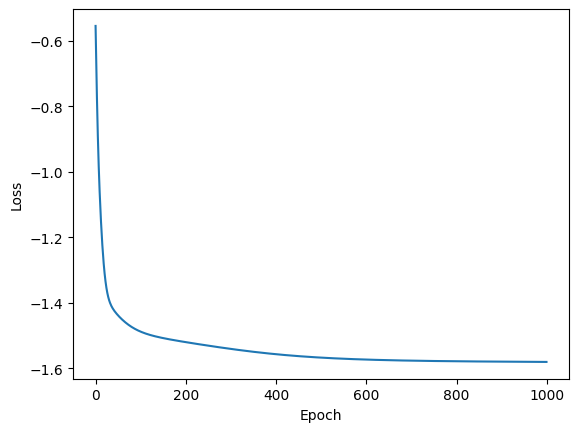

In [17]:
from re import L
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

from torch import optim
from torch.utils import data
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

import statistics
import datetime
import os
import csv
import math
import time
import numpy as np
import os

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)
x_train, x_test, y_train, y_test = train_test_split(X_tensor, Y_tensor, test_size=0.1, random_state=41)
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size = 16)
testdataloader = DataLoader(TensorDataset(x_test, y_test))

n1 = 20
n2 = 10

# Define the neural network class
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(5, n1)
        self.fc2 = torch.nn.Linear(n1, n2)
        self.fc3 = torch.nn.Linear(n2, 1)
        self.dropout = torch.nn.Dropout(0.1)
        self.tanh = torch.nn.Tanh()
        self.bn1 = torch.nn.BatchNorm1d(n1)
        self.bn2 = torch.nn.BatchNorm1d(n2)
        self.bn3 = torch.nn.BatchNorm1d(1)

    def forward(self, x):
        x = self.fc1(x)
        #x = self.bn1(x)
        x = self.tanh(x)
        #x = self.dropout(x)
        x = self.fc2(x)
        #x = self.bn2(x)
        x = self.tanh(x)
        #x = self.dropout(x)
        x = self.fc3(x)
        #x = self.bn3(x)
        return x

# Create an instance of the MLP class
model = MLP()

def initialize_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

model.apply(initialize_weights)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
#torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

nb_epochs = 1000
MLoss = []
for epoch in range(0, nb_epochs):

    current_loss = 0.0
    losses = []
    # Iterate over the dataloader for training data
    for i, data in enumerate(dataloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0],1))
        #zero the gradients
        optimizer.zero_grad()
        #perform forward pass
        outputs = model(inputs)
        L_weight = 3
        #compute loss
        batch_loss = []
        for j in range(inputs.size(0)):
            input_j = inputs[j].reshape((1, inputs.shape[1]))
            if input_j[0,0]>0.3:
                batch_loss.append(L_weight*loss_function(outputs[j], targets[j]))
            else:
                batch_loss.append(loss_function(outputs[j], targets[j]))
        loss = torch.stack(batch_loss).mean()
        losses.append(loss.item())
        #perform backward pass
        loss.backward()
        #perform optimization
        optimizer.step()
        # Print statistics

    mean_loss = sum(losses)/len(losses)
    scheduler.step(mean_loss)

    print('Loss (epoch: %4d): %.8f' %(epoch+1, mean_loss))
    current_loss = 0.0
    MLoss.append(mean_loss)

# Process is complete.
#print('Training process has finished.')

torch.save(model, 'IWO_idvg.pt')
torch.save(model.state_dict(), 'IWO_idvg_state_dict.pt')

####### loss vs. epoch #######
xloss = list(range(0, nb_epochs))
plt.plot(xloss, np.log10(MLoss))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()



In [18]:
with torch.no_grad():

    output = []
    # Iterate over the dataloader for training data
    for i, data in enumerate(testdataloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0],1))

        #zero the gradients
        optimizer.zero_grad()

        #perform forward pass
        outputs = model(inputs)
        output.append(outputs)
# Process is complete.
#print('Training process has finished.')

# Extract the weights and biases from the model
weights_1 = model.fc1.weight.detach().numpy()
bias_1 = model.fc1.bias.detach().numpy()
weights_2 = model.fc2.weight.detach().numpy()
bias_2 = model.fc2.bias.detach().numpy()
weights_3 = model.fc3.weight.detach().numpy()
bias_3 = model.fc3.bias.detach().numpy()

def generate_variable_declarations(weights_shape, layer_prefix):
    declarations = ""
    num_neurons = weights_shape  # Number of neurons is determined by the first dimension of the weights matrix
    layer_declarations = ", ".join([f"{layer_prefix}_{i}" for i in range(num_neurons)]) + ";"
    declarations += layer_declarations
    return declarations

# Use the function to generate declarations for each layer
h1_declarations = generate_variable_declarations(weights_1.shape[0], "hvth1")
h2_declarations = generate_variable_declarations(weights_2.shape[0], "hvth2")

verilog_code = """
// VerilogA for GB_lib, IWO_verliogA, veriloga
//*******************************************************************************
//* * School of Electrical and Computer Engineering, Georgia Institute of Technology
//* PI: Prof. Shimeng Yu
//* All rights reserved.
//*
//* Copyright of the model is maintained by the developers, and the model is distributed under
//* the terms of the Creative Commons Attribution-NonCommercial 4.0 International Public License
//* http://creativecommons.org/licenses/by-nc/4.0/legalcode.
//*
//* THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
//* ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
//* WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
//* DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
//* FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
//* DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
//* SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
//* CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
//* OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
//* OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
//*
//* Developer:
//*  Gihun Choe gchoe6@gatech.edu
//********************************************************************************/

`include "constants.vams"
`include "disciplines.vams"


module IWO_verliogA(d, g, s);
        inout d, g, s;
        electrical d, g, s;

        //***** parameters L and W ******//
        parameter real W = 0.1; //get parameter fom spectre
        parameter real L = 0.05; //get parameter fom spectre
        parameter real T_stress = 0.0001; //set on cadence as variable
        parameter real T_rec = 0.001;     //set on cadence as variable
        parameter real Clk_loops = 50;    //set on cadence as variable
        parameter real V_ov = 1.7;        //set on cadence as variable
        parameter real Temp = 25;  //set on cadence as variable

        parameter MinVg = -1.0 ;
        parameter normVg = 0.2222222222222222 ;
        parameter MinVd = 0.01 ;
        parameter normVd = 0.2949852507374631 ;
        parameter MinLg = 0.05 ;
        parameter normLg = 1.4285714285714286 ;
        parameter MinO = 8.15e-15 ;
        parameter normO =33613445378151.26;
        parameter MinI = -23.98798356587402 ;
        parameter normI =0.04615548498417793;

        parameter Mint_stress = {} ;
        parameter normt_stress = {} ;
        parameter Mint_rec = {} ;
        parameter normt_rec = {} ;
        parameter Minclk_loops = {} ;
        parameter normclk_loops = {} ;
        parameter Minv_ov = {} ;
        parameter normv_ov = {} ;
        parameter Mintemperature = {} ;
        parameter normtemperature = {} ;
        parameter Mindelta_Vth = {} ;
        parameter normdelta_Vth = {} ;

        real {}
        real {}

        real Vg, Vd, Vs, Vgs, Vds, Lg, Id, Cgg, Cgsd, Vgd;
        real Vgsraw, Vgdraw, dir;
        real t_stress, v_ov, t_rec, clk_loops, temp, delta_Vth;

        real h1_0, h1_1, h1_2, h1_3, h1_4, h1_5, h1_6, h1_7, h1_8, h1_9, h1_10, h1_11, h1_12, h1_13, h1_14, h1_15, h1_16, h1_17, h1_18, h1_19, h1_20, h1_21, h1_22, h1_23, h1_24;
        real h2_0, h2_1, h2_2, h2_3, h2_4, h2_5, h2_6, h2_7, h2_8, h2_9, h2_10, h2_11, h2_12, h2_13, h2_14, h2_15, h2_16, y;
        real hc1_0, hc1_1, hc1_2, hc1_3, hc1_4, hc1_5, hc1_6, hc1_7, hc1_8, hc1_9;
        real hc1_10, hc1_11, hc1_12, hc1_13, hc1_14, hc1_15, hc1_16;
        real hc2_0, hc2_1, hc2_2, hc2_3, hc2_4, hc2_5, hc2_6, hc2_7, hc2_8, hc2_9;
        real hc2_10, hc2_11, hc2_12, hc2_13, hc2_14, hc2_15, hc2_16, yc, yvth;

analog begin

t_stress = (T_stress - Mint_stress)*normt_stress;
v_ov = (V_ov - Minv_ov)*normv_ov;
t_rec = (T_rec - Mint_rec)*normt_rec ;
clk_loops = (Clk_loops - Minclk_loops)*normclk_loops ;
temp = (Temp - Mintemperature)*normtemperature ;

//******************** delta_Vth NN **********************************//

""".format(Mint_stress, normt_stress, Mint_rec, normt_rec, Minclk_loops, normclk_loops, MinV_ov, normV_ov, Mintemperature, normtemperature, Mindelta_Vth, normdelta_Vth, h1_declarations, h2_declarations)
# V_ov = (V_ov - MinV_ov)*normV_ov ;
# t_stress = (T_stress - Mint_stress)*normt_stress ;

# Create the Verilog-A code for the 1st hidden layer
for i in range(n1):
    inputs = ["t_stress", "t_rec", "clk_loops", "v_ov", "temp"]
    inputs = ["*".join([str(weights_1[i][j]), inp]) for j, inp in enumerate(inputs)]
    inputs = "+".join(inputs)
    inputs = "+".join([inputs, str(bias_1[i])])
    verilog_code += "hvth1_{} = tanh({});\n".format(i, inputs)
verilog_code += "\n"

# Create the Verilog-A code for the 2nd hidden layer
for i in range(n2):
    inputs = ["hvth1_{}".format(j) for j in range(n1)]
    inputs = ["*".join([str(weights_2[i][j]), inp]) for j, inp in enumerate(inputs)]
    inputs = "+".join(inputs)
    inputs = "+".join([inputs, str(bias_2[i])])
    verilog_code += "hvth2_{} = tanh({});\n".format(i, inputs)
verilog_code += "\n"

# Create the Verilog-A code for the output layer
inputs = ["hvth2_{}".format(i) for i in range(n2)]
inputs = ["*".join([str(weights_3[0][i]), inp]) for i, inp in enumerate(inputs)]
inputs = "+".join(inputs)
inputs = "+".join([inputs, str(bias_3[0])])
verilog_code += "yvth = {};\n\n".format(inputs)
verilog_code += "delta_Vth = (yvth - Mindelta_Vth) * normdelta_Vth;\n"
verilog_code += """$strobe("dvth=$g",delta_Vth);"""
verilog_code += """


        Vg = V(g) ;
        Vs = V(s) ;
        Vd = V(d) ;
        Vgsraw = Vg-Vs ;
        Vgdraw = Vg-Vd ;

if (Vgsraw >= Vgdraw) begin
        Vgs = ((Vg-Vs) - MinVg) * normVg ;
        dir = 1;
end

else begin
        Vgs = ((Vg-Vd) - MinVg) * normVg ;
        dir = -1;
end

        Vds = (abs(Vd-Vs) - MinVd) * normVd ;
        Vgs = Vgs - delta_Vth ; // BTI Vth variation
        Lg = (L -MinLg)*normLg ;



//******************** C-V NN **********************************//
hc1_0 = tanh(-0.99871427*Vgs+-0.16952373*Vds+0.32118186*Lg+0.41485423);
hc1_1 = tanh(0.31587568*Vgs+0.13397887*Vds+-0.4541538*Lg+-0.3630942);
hc1_2 = tanh(-0.76281804*Vgs+0.09352969*Vds+1.1961353*Lg+0.3904977);
hc1_3 = tanh(-1.115087*Vgs+0.85752946*Vds+-0.11746484*Lg+0.5500279);
hc1_4 = tanh(1.0741386*Vgs+0.82041687*Vds+0.19092631*Lg+-0.4009425);
hc1_5 = tanh(-0.47921795*Vgs+-0.8749933*Vds+-0.054768667*Lg+0.62785167);
hc1_6 = tanh(0.5449184*Vgs+-4.409165*Vds+-0.072947875*Lg+-0.31324536);
hc1_7 = tanh(-2.9224303*Vgs+2.7675478*Vds+0.08862238*Lg+0.6493558);
hc1_8 = tanh(0.65050656*Vgs+-0.29751927*Vds+0.1571876*Lg+-0.38088372);
hc1_9 = tanh(-0.30384183*Vgs+0.5649165*Vds+2.6806898*Lg+0.3197917);
hc1_10 = tanh(-0.095988505*Vgs+2.0158541*Vds+-0.42972717*Lg+-0.30388466);
hc1_11 = tanh(6.7699738*Vgs+-0.07234483*Vds+-0.013545353*Lg+-1.3694142);
hc1_12 = tanh(-0.3404029*Vgs+0.0443459*Vds+0.89597*Lg+0.069993004);
hc1_13 = tanh(0.62300175*Vgs+-0.29515797*Vds+1.6753465*Lg+-0.6520838);
hc1_14 = tanh(0.37957156*Vgs+0.2237372*Vds+0.08591952*Lg+0.13126835);
hc1_15 = tanh(0.19949242*Vgs+-0.26481664*Vds+-0.41059187*Lg+-0.40832308);
hc1_16 = tanh(0.98966587*Vgs+-0.24259183*Vds+0.36584845*Lg+-0.8024042);

hc2_0 = tanh(-0.91327864*hc1_0+0.4696781*hc1_1+0.3302202*hc1_2+0.11393868*hc1_3+0.45070222*hc1_4+-0.2894044*hc1_5+0.55066*hc1_6+-1.6242687*hc1_7+-0.38140613*hc1_8+0.032771554*hc1_9+0.17647126);
hc2_1 = tanh(-1.1663305*hc1_0+-0.523984*hc1_1+-0.90804136*hc1_2+-0.7418044*hc1_3+1.456171*hc1_4+-0.16802542*hc1_5+0.8235596*hc1_6+-2.2246246*hc1_7+-0.40805355*hc1_8+0.7207601*hc1_9+0.4729169);
hc2_2 = tanh(-0.69065374*hc1_0+0.40205315*hc1_1+-0.49410668*hc1_2+0.8681325*hc1_3+0.471351*hc1_4+0.46939445*hc1_5+0.45568785*hc1_6+-0.92935294*hc1_7+-0.8209646*hc1_8+0.1158967*hc1_9+-0.075798474);
hc2_3 = tanh(0.11535446*hc1_0+-0.06296927*hc1_1+-0.6740435*hc1_2+0.7428315*hc1_3+0.05890677*hc1_4+0.9579441*hc1_5+-0.037319*hc1_6+-0.18491426*hc1_7+-0.02981994*hc1_8+0.038347963*hc1_9+0.039531134);
hc2_4 = tanh(0.37817463*hc1_0+-0.6811279*hc1_1+1.1388369*hc1_2+0.19983096*hc1_3+-0.20415118*hc1_4+1.3022176*hc1_5+0.22571652*hc1_6+0.1690611*hc1_7+-0.56475276*hc1_8+-0.4069731*hc1_9+0.99962974);
hc2_5 = tanh(0.032873478*hc1_0+-0.05209407*hc1_1+-0.010839908*hc1_2+-0.13892579*hc1_3+-0.050480977*hc1_4+0.0127089145*hc1_5+0.0052771433*hc1_6+0.02029242*hc1_7+-0.08705659*hc1_8+0.0254766*hc1_9+0.025135752);
hc2_6 = tanh(-0.34639204*hc1_0+0.06937975*hc1_1+0.18671949*hc1_2+-0.18912783*hc1_3+0.1312504*hc1_4+0.4627272*hc1_5+-0.42590702*hc1_6+-0.10966313*hc1_7+0.66083515*hc1_8+-0.050718334*hc1_9+0.08234678);
hc2_7 = tanh(0.90656275*hc1_0+-0.037281644*hc1_1+0.77237594*hc1_2+1.4710428*hc1_3+0.13597831*hc1_4+-0.059844542*hc1_5+-0.7801535*hc1_6+3.7814677*hc1_7+-0.5976644*hc1_8+0.2721995*hc1_9+0.023777716);
hc2_8 = tanh(0.39720625*hc1_0+-0.45262313*hc1_1+0.19873238*hc1_2+0.9750888*hc1_3+-0.9427992*hc1_4+0.4487432*hc1_5+-0.3372945*hc1_6+0.33729544*hc1_7+-0.1667088*hc1_8+-0.5707525*hc1_9+0.27954483);
hc2_9 = tanh(0.28551984*hc1_0+-0.68350387*hc1_1+0.9916423*hc1_2+-0.8254094*hc1_3+0.09875706*hc1_4+0.47609732*hc1_5+-0.058662917*hc1_6+0.09181381*hc1_7+0.09592329*hc1_8+1.3940467*hc1_9+0.3865768);
hc2_10 = tanh(0.098737516*hc1_0+0.060473576*hc1_1+0.42824662*hc1_2+0.15018038*hc1_3+0.082621895*hc1_4+-0.00019039502*hc1_5+-0.3321634*hc1_6+0.7936295*hc1_7+-0.041197542*hc1_8+0.6530619*hc1_9+0.1338804);
hc2_11 = tanh(-0.3585284*hc1_0+-0.09956017*hc1_1+0.17224246*hc1_2+-0.016925728*hc1_3+-0.46462816*hc1_4+-0.5649022*hc1_5+1.251695*hc1_6+-0.4303161*hc1_7+0.48546878*hc1_8+0.22958975*hc1_9+-0.27899802);
hc2_12 = tanh(0.8565631*hc1_0+-0.7622999*hc1_1+0.32367912*hc1_2+1.4776785*hc1_3+0.2712369*hc1_4+0.2275511*hc1_5+0.39908803*hc1_6+4.2305493*hc1_7+-0.3467536*hc1_8+0.41231114*hc1_9+0.47123823);
hc2_13 = tanh(-0.26411077*hc1_0+-0.17583853*hc1_1+0.045439184*hc1_2+-0.13801138*hc1_3+0.03278085*hc1_4+-0.45625108*hc1_5+-0.17905861*hc1_6+0.3060186*hc1_7+-0.3361926*hc1_8+-0.050055273*hc1_9+0.17996444);
hc2_14 = tanh(0.016094366*hc1_0+-0.013196736*hc1_1+0.4124856*hc1_2+0.22926371*hc1_3+-0.35071182*hc1_4+-0.34217188*hc1_5+-0.69466996*hc1_6+1.0563152*hc1_7+-0.18019852*hc1_8+0.061871335*hc1_9+0.09762555);
hc2_15 = tanh(-0.18970782*hc1_0+0.3624813*hc1_1+-1.3419824*hc1_2+0.103635244*hc1_3+-0.14595217*hc1_4+-0.1899393*hc1_5+0.176524*hc1_6+-0.4428012*hc1_7+-0.39544868*hc1_8+-0.45783517*hc1_9+0.1884755);
hc2_16 = tanh(-0.1585831*hc1_0+0.035894837*hc1_1+-0.14261873*hc1_2+0.25914294*hc1_3+0.040607046*hc1_4+0.11555795*hc1_5+0.0022548323*hc1_6+-0.002149359*hc1_7+0.07067297*hc1_8+0.019578662*hc1_9+0.16657573);
yc = 0.17503543*hc2_0+-0.15556754*hc2_1+-0.125455*hc2_2+-0.07502612*hc2_3+-0.16671115*hc2_4+0.29854503;

Cgg = (yc / normO + MinO)*W;
Cgsd = Cgg/2 ;

//******************** I-V NN **********************************//
h1_0 = tanh(0.0023826673*Vgs+-0.0009636134*Vds+0.006639037*Lg+-0.0004692053);
h1_1 = tanh(-7.8007555*Vgs+2.639791*Vds+-0.025273597*Lg+-1.1747514);
h1_2 = tanh(1.9884652*Vgs+0.62111*Vds+-0.11525345*Lg+-0.14575638);
h1_3 = tanh(0.10625471*Vgs+0.09442053*Vds+-0.052119628*Lg+1.1568379);
h1_4 = tanh(4.058087*Vgs+-0.7568158*Vds+0.008070099*Lg+-0.4820452);
h1_5 = tanh(-1.3065948*Vgs+-0.0492497*Vds+-0.081622526*Lg+0.20351954);
h1_6 = tanh(-2.9507525*Vgs+-0.91150546*Vds+-0.06477873*Lg+0.09646383);
h1_7 = tanh(-0.5886177*Vgs+0.63788587*Vds+-0.13710928*Lg+0.30260038);
h1_8 = tanh(-0.4311161*Vgs+-0.7250705*Vds+-0.06134645*Lg+0.44054285);
h1_9 = tanh(0.012132638*Vgs+-0.42545322*Vds+-0.66478956*Lg+0.13182367);
h1_10 = tanh(3.289041e-05*Vgs+0.0011367714*Vds+-0.0051904405*Lg+5.4112927e-05);
h1_11 = tanh(-0.6007774*Vgs+0.09259224*Vds+0.2170182*Lg+-0.2908748);
h1_12 = tanh(0.28018302*Vgs+1.3014064*Vds+-0.13490067*Lg+-0.22006753);
h1_13 = tanh(0.01864017*Vgs+-13.0928755*Vds+-0.0037254083*Lg+-0.10935691);
h1_14 = tanh(-0.0049708197*Vgs+0.0022613218*Vds+-0.014408149*Lg+0.0011340647);
h1_15 = tanh(-0.094654046*Vgs+-0.4174114*Vds+0.18892045*Lg+0.05248958);
h1_16 = tanh(-0.25090316*Vgs+-0.11111481*Vds+-0.009133225*Lg+0.08377026);
h1_17 = tanh(0.9275306*Vgs+0.40686756*Vds+0.14127344*Lg+-0.059246097);
h1_18 = tanh(-0.27084363*Vgs+0.07915911*Vds+-10.836302*Lg+-1.1535788);
h1_19 = tanh(1.6852072*Vgs+-0.24846223*Vds+0.049734037*Lg+-0.19625053);

h2_0 = tanh(1.1139417*h1_0+-0.40033522*h1_1+0.920759*h1_2+0.47607598*h1_3+0.3978683*h1_4+0.8008105*h1_5+-0.40445566*h1_6+0.8668027*h1_7+0.23365597*h1_8+-0.28254375*h1_9+-0.63985884*h1_10+-0.62523574*h1_11+0.8338383*h1_12+-2.0540943*h1_13+1.0749483*h1_14+-1.1075479*h1_15+0.60926706*h1_16+1.1118286*h1_17+-0.8917559*h1_18+0.029025732*h1_19+0.6622382);
h2_1 = tanh(0.37195024*h1_0+-0.761445*h1_1+0.6514153*h1_2+0.6211995*h1_3+-0.063539445*h1_4+0.31260127*h1_5+-0.3529579*h1_6+0.50422627*h1_7+0.18943883*h1_8+-0.38029787*h1_9+-0.3464503*h1_10+-0.48301366*h1_11+0.081978925*h1_12+-0.08305682*h1_13+-0.08420117*h1_14+-0.8029313*h1_15+-0.37052512*h1_16+0.4553502*h1_17+-0.71959645*h1_18+-0.17320661*h1_19+0.6566257);
h2_2 = tanh(-0.021933522*h1_0+-0.017245224*h1_1+0.030417712*h1_2+0.2967218*h1_3+-0.048668377*h1_4+0.029245213*h1_5+0.011756416*h1_6+0.004705658*h1_7+-0.042515088*h1_8+0.010462476*h1_9+0.001331279*h1_10+0.1694541*h1_11+-0.010949079*h1_12+-0.004144526*h1_13+0.04856694*h1_14+-0.010465159*h1_15+0.24588406*h1_16+-0.028521152*h1_17+0.12161568*h1_18+0.1753255*h1_19+-0.09125355);
h2_3 = tanh(-0.025546636*h1_0+-3.2702503*h1_1+0.46812135*h1_2+-0.25135994*h1_3+3.0725436*h1_4+0.22513995*h1_5+-1.0327209*h1_6+-0.56274736*h1_7+0.4726107*h1_8+0.38182434*h1_9+0.016403453*h1_10+-0.09128962*h1_11+0.20997792*h1_12+-0.4951615*h1_13+0.026481293*h1_14+0.6085288*h1_15+-0.09078652*h1_16+0.36613584*h1_17+0.26257026*h1_18+0.39794916*h1_19+-0.52920526);
h2_4 = tanh(-0.44392154*h1_0+-0.5650475*h1_1+0.91716766*h1_2+0.96703196*h1_3+0.4597048*h1_4+1.452921*h1_5+-0.8115141*h1_6+0.92326456*h1_7+0.2862403*h1_8+-0.9441585*h1_9+0.22188367*h1_10+-1.0092766*h1_11+0.5495966*h1_12+0.44870532*h1_13+0.48705962*h1_14+-0.6957133*h1_15+0.27711377*h1_16+1.0138507*h1_17+-0.34337458*h1_18+-0.21548931*h1_19+0.42685974);
h2_5 = tanh(0.0003710325*h1_0+0.5746112*h1_1+0.4144258*h1_2+0.04459103*h1_3+1.2373503*h1_4+0.12786175*h1_5+-0.16099685*h1_6+0.9826207*h1_7+-0.09701193*h1_8+-0.4379135*h1_9+-0.0035542254*h1_10+0.04205593*h1_11+0.65820116*h1_12+0.3810506*h1_13+0.0004259507*h1_14+-0.21782044*h1_15+-0.057544652*h1_16+0.24420041*h1_17+-0.10138292*h1_18+-0.2387106*h1_19+0.867847);
h2_6 = tanh(-0.0077049686*h1_0+-0.05349668*h1_1+-0.11536639*h1_2+0.06141029*h1_3+-0.034344573*h1_4+0.21672213*h1_5+-0.09835135*h1_6+-0.25849992*h1_7+0.10576329*h1_8+-0.14288934*h1_9+0.027846925*h1_10+-0.20104973*h1_11+0.24784875*h1_12+0.03396087*h1_13+-0.016039118*h1_14+-0.03147038*h1_15+-0.023109786*h1_16+-0.118931994*h1_17+0.18256636*h1_18+0.09981429*h1_19+0.079372324);
h2_7 = tanh(-0.009369999*h1_0+-2.4468672*h1_1+-0.41433397*h1_2+-0.6289744*h1_3+-1.8285819*h1_4+0.12905455*h1_5+0.83588725*h1_6+0.11491322*h1_7+0.3871084*h1_8+0.07153052*h1_9+0.013530584*h1_10+0.40614852*h1_11+0.10340061*h1_12+-0.04473306*h1_13+0.0075287875*h1_14+0.5593612*h1_15+0.34401885*h1_16+-0.5538749*h1_17+0.36615464*h1_18+-0.2666981*h1_19+0.20194086);
h2_8 = tanh(-0.0017045025*h1_0+-1.1388719*h1_1+0.25932005*h1_2+-0.6482845*h1_3+2.263395*h1_4+0.115192235*h1_5+-0.40946937*h1_6+-0.038117886*h1_7+-0.03703431*h1_8+0.05965774*h1_9+0.0032721795*h1_10+0.2561857*h1_11+0.47324425*h1_12+-0.25200802*h1_13+0.0017081021*h1_14+0.29819545*h1_15+0.061945435*h1_16+0.13516657*h1_17+0.5409335*h1_18+-0.17400871*h1_19+0.11659722);
h2_9 = tanh(0.014866875*h1_0+1.0399909*h1_1+1.0108095*h1_2+-0.0918755*h1_3+-0.7634763*h1_4+-0.49749368*h1_5+-0.7020006*h1_6+-0.16384888*h1_7+-0.07833025*h1_8+-0.23745225*h1_9+-0.023095092*h1_10+-0.29244414*h1_11+0.6255917*h1_12+0.41413808*h1_13+-0.019823061*h1_14+-1.0593235*h1_15+-0.42221433*h1_16+0.98025715*h1_17+-0.71444243*h1_18+0.84347373*h1_19+0.28510216);
h2_10 = tanh(-0.013515852*h1_0+0.68840384*h1_1+-0.030184174*h1_2+-0.48098114*h1_3+0.08609854*h1_4+-0.50878614*h1_5+0.26547763*h1_6+-0.7151076*h1_7+0.111288495*h1_8+0.53379977*h1_9+0.022258151*h1_10+0.16971351*h1_11+-1.2486296*h1_12+0.9649942*h1_13+0.0028906881*h1_14+0.31582054*h1_15+0.24213083*h1_16+-0.27242163*h1_17+0.11330636*h1_18+0.17038865*h1_19+-0.42089102);
h2_11 = tanh(-0.009949424*h1_0+-0.6704206*h1_1+0.13177924*h1_2+0.07316155*h1_3+-0.28207502*h1_4+-0.32401362*h1_5+0.020746209*h1_6+-0.05517531*h1_7+0.10340257*h1_8+0.29381263*h1_9+0.020497978*h1_10+0.031984854*h1_11+0.079552434*h1_12+-7.7884445*h1_13+0.01224806*h1_14+0.8700812*h1_15+-0.16562358*h1_16+0.14370379*h1_17+0.2389181*h1_18+-0.19771136*h1_19+0.33039534);
h2_12 = tanh(-0.002431529*h1_0+0.30154988*h1_1+-0.45072728*h1_2+0.27823612*h1_3+-0.25173753*h1_4+-0.58188903*h1_5+0.39836177*h1_6+-0.060329597*h1_7+0.1667837*h1_8+-0.09419194*h1_9+0.0108116735*h1_10+-0.3581154*h1_11+0.15690842*h1_12+-0.41209573*h1_13+-0.0070331707*h1_14+-0.23976392*h1_15+0.16620094*h1_16+-0.034617994*h1_17+0.32754526*h1_18+0.8490298*h1_19+0.026407415);
h2_13 = tanh(-0.7385622*h1_0+-0.25174448*h1_1+2.090295*h1_2+0.67499936*h1_3+0.07392262*h1_4+0.5413692*h1_5+-0.8287433*h1_6+2.2810504*h1_7+1.1917778*h1_8+1.3719273*h1_9+0.25762329*h1_10+-2.1111712*h1_11+1.6987114*h1_12+-0.437825*h1_13+1.7649944*h1_14+-2.2254016*h1_15+-2.3555171*h1_16+-0.7732424*h1_17+-1.0756916*h1_18+-0.1367373*h1_19+1.5085722);
h2_14 = tanh(-0.002535408*h1_0+-4.2686224*h1_1+-0.045537975*h1_2+0.08043166*h1_3+1.7274952*h1_4+-0.1260494*h1_5+-0.23011239*h1_6+-0.21025337*h1_7+0.48537356*h1_8+0.39049447*h1_9+-0.006565428*h1_10+-0.293028*h1_11+-1.1253971*h1_12+-0.2890831*h1_13+0.0042421576*h1_14+0.4230598*h1_15+-0.17869289*h1_16+-0.034056116*h1_17+0.61135995*h1_18+0.6345532*h1_19+0.73144835);
h2_15 = tanh(-0.5239093*h1_0+0.49806875*h1_1+0.53555894*h1_2+1.2645539*h1_3+1.011548*h1_4+0.39209503*h1_5+-0.78194916*h1_6+0.94610345*h1_7+0.9121405*h1_8+-1.4693716*h1_9+-0.58336824*h1_10+-1.1661471*h1_11+-0.16158457*h1_12+0.058512915*h1_13+1.3358645*h1_14+0.5742125*h1_15+-1.3325212*h1_16+1.1804186*h1_17+-1.4877121*h1_18+0.6357802*h1_19+1.1328585);
h2_16 = tanh(0.0095406*h1_0+-0.53232694*h1_1+0.1535685*h1_2+0.26108417*h1_3+-0.08375187*h1_4+0.3462123*h1_5+-0.61755395*h1_6+0.0015145333*h1_7+-0.108780764*h1_8+0.2555477*h1_9+0.00023940884*h1_10+-0.26577523*h1_11+-0.27689674*h1_12+0.43049082*h1_13+-0.025424613*h1_14+0.24634649*h1_15+-0.22579487*h1_16+0.37249807*h1_17+-0.8058662*h1_18+-0.77451354*h1_19+0.5821276);
y = -0.17525196*h2_0+-0.22995844*h2_1+0.0026147955*h2_2+0.091129646*h2_3+-0.4534783*h2_4+0.4119419*h2_5+-1.4205361e-05*h2_6+-0.11359831*h2_7+0.1762025*h2_8+-0.1002102*h2_9+-0.37161925*h2_10+0.2683793*h2_11+0.051897053*h2_12+0.19354156*h2_13+-0.10134394*h2_14+0.3937854*h2_15+-0.3296008*h2_16+0.3220947;

        Id = pow(10, (y/normI + MinI)) ;

if (Id <= 1e-15) begin //limit
        Id = 1e-15;
        //Id = Id;
end
else begin
        Id = Id;
end  //limit end


        I(g, d) <+ Cgsd*ddt(Vg-Vd) ;
        I(g, s) <+ Cgsd*ddt(Vg-Vs) ;

if (Vgsraw >= Vgdraw) begin
        I(d, s) <+ dir*Id*W ;

end

else begin
        I(d, s) <+ dir*Id*W ;

end

end

endmodule

"""

print(verilog_code)



// VerilogA for GB_lib, IWO_verliogA, veriloga
//*******************************************************************************
//* * School of Electrical and Computer Engineering, Georgia Institute of Technology
//* PI: Prof. Shimeng Yu
//* All rights reserved.
//*
//* Copyright of the model is maintained by the developers, and the model is distributed under
//* the terms of the Creative Commons Attribution-NonCommercial 4.0 International Public License
//* http://creativecommons.org/licenses/by-nc/4.0/legalcode.
//*
//* THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
//* ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
//* WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
//* DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
//* FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
//* DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOO

1.10036881607686
0.04321379542061602
(29, 1, 1)


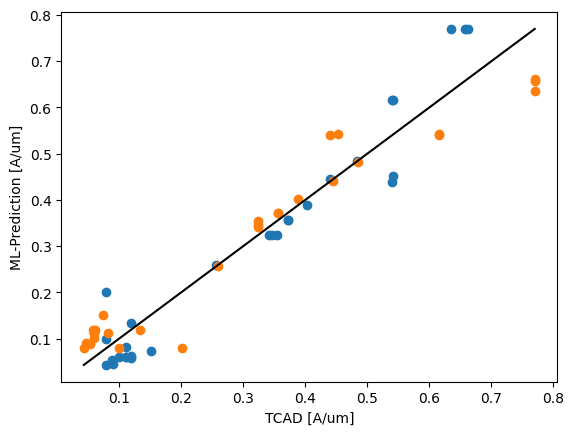

Predicted delta_V: 0.4370737671852112V


<ipython-input-26-0ddd2f296d2b>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Predicted delta_V: {}V".format(float(pred_y)))


In [26]:
output1 = np.array(output)/normdelta_Vth + Mindelta_Vth
ytest1 = np.array(y_test)/normdelta_Vth + Mindelta_Vth
print(normdelta_Vth)
print(Mindelta_Vth)
print(np.shape(output1))

plt.scatter(output1, ytest1)
a = [min(ytest1), max(ytest1)]
b = [min(ytest1), max(ytest1)]
plt.plot(a,b,'k')
plt.scatter(ytest1,output1)
plt.xlabel("TCAD [A/um]")
plt.ylabel("ML-Prediction [A/um]")
plt.show()

tp = [0.0001, 0.0001, 1000, 1.7, 25] # [t_st, t_rec, clk_loops, V_ov, temperature]
new_var = torch.FloatTensor([(tp[0]-Mint_stress)*normt_stress, (tp[1]-Mint_rec)*normt_rec, (tp[2]-Minclk_loops)*normclk_loops, (tp[3]-MinV_ov)*normV_ov, (tp[4] - Mintemperature)* normtemperature])
pred_y=model(new_var).data.numpy()
print("Predicted delta_V: {}V".format(float(pred_y)))

    
    ===========================================


**Layer 1**

Loss (epoch:    1): 1.20045621
Loss (epoch:    2): 1.15505596
Loss (epoch:    3): 1.11135498
Loss (epoch:    4): 1.06911688
Loss (epoch:    5): 1.02834294
Loss (epoch:    6): 0.98902388
Loss (epoch:    7): 0.95113640
Loss (epoch:    8): 0.91464892
Loss (epoch:    9): 0.87952644
Loss (epoch:   10): 0.84573260
Loss (epoch:   11): 0.81323153
Loss (epoch:   12): 0.78198754
Loss (epoch:   13): 0.75196593
Loss (epoch:   14): 0.72313262
Loss (epoch:   15): 0.69545401
Loss (epoch:   16): 0.66889699
Loss (epoch:   17): 0.64342882
Loss (epoch:   18): 0.61901712
Loss (epoch:   19): 0.59562984
Loss (epoch:   20): 0.57323520
Loss (epoch:   21): 0.55180176
Loss (epoch:   22): 0.53129842
Loss (epoch:   23): 0.51169426
Loss (epoch:   24): 0.49295860
Loss (epoch:   25): 0.47506112
Loss (epoch:   26): 0.45797173
Loss (epoch:   27): 0.44166082
Loss (epoch:   28): 0.42609887
Loss (epoch:   29): 0.41125691
Loss (epoch:   30): 0.39710635
Loss (epoch:   31): 0.38361906
Loss (epoch:   32): 0.37076722
Loss (ep

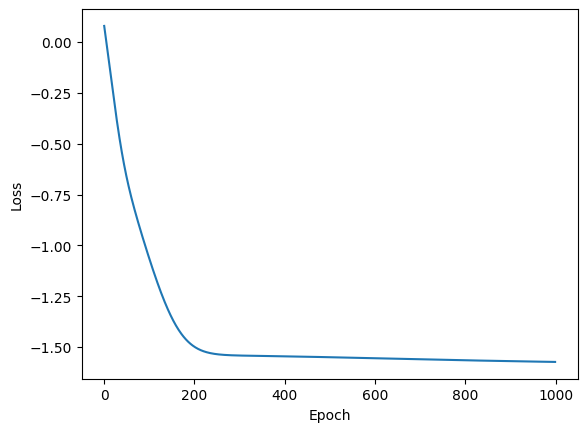

In [18]:
from re import L
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

from torch import optim
from torch.utils import data
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

import statistics
import datetime
import os
import csv
import math
import time
import numpy as np
import os

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_tensor = torch.tensor(X, dtype=torch.float64)
Y_tensor = torch.tensor(Y, dtype=torch.float64)
x_train, x_test, y_train, y_test = train_test_split(X_tensor, Y_tensor, test_size=0.1, random_state=41)
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size = 32)
testdataloader = DataLoader(TensorDataset(x_test, y_test))

n1 = 20
#n2 = 10

# Define the neural network class
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(5, n1)
        self.fc2 = torch.nn.Linear(n1, n2)
        self.fc3 = torch.nn.Linear(n2, 1)
        self.fc4 = torch.nn.Linear(n1, 1)
        self.dropout = torch.nn.Dropout(0.1)
        self.tanh = torch.nn.Tanh()
        self.bn1 = torch.nn.BatchNorm1d(n1)
        self.bn2 = torch.nn.BatchNorm1d(n2)
        self.bn3 = torch.nn.BatchNorm1d(1)

    def forward(self, x):
        x = self.fc1(x)
        #x = self.bn1(x)
        x = self.tanh(x)
        #x = self.dropout(x)
        #x = self.fc2(x)
        #x = self.bn2(x)
        #x = self.tanh(x)
        #x = self.dropout(x)
        #x = self.fc3(x)
        #x = self.bn3(x)
        x = self.fc4(x)
        return x

# Create an instance of the MLP class
model = MLP()

def initialize_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

model.apply(initialize_weights)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
#torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

nb_epochs = 1000
MLoss = []
for epoch in range(0, nb_epochs):

    current_loss = 0.0
    losses = []
    # Iterate over the dataloader for training data
    for i, data in enumerate(dataloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0],1))
        #zero the gradients
        optimizer.zero_grad()
        #perform forward pass
        outputs = model(inputs)
        L_weight = 3
        #compute loss
        batch_loss = []
        for j in range(inputs.size(0)):
            input_j = inputs[j].reshape((1, inputs.shape[1]))
            if input_j[0,0]>0.3:
                batch_loss.append(L_weight*loss_function(outputs[j], targets[j]))
            else:
                batch_loss.append(loss_function(outputs[j], targets[j]))
        loss = torch.stack(batch_loss).mean()
        losses.append(loss.item())
        #perform backward pass
        loss.backward()
        #perform optimization
        optimizer.step()
        # Print statistics

    mean_loss = sum(losses)/len(losses)
    scheduler.step(mean_loss)

    print('Loss (epoch: %4d): %.8f' %(epoch+1, mean_loss))
    current_loss = 0.0
    MLoss.append(mean_loss)

# Process is complete.
#print('Training process has finished.')

torch.save(model, 'IWO_idvg.pt')
torch.save(model.state_dict(), 'IWO_idvg_state_dict.pt')

####### loss vs. epoch #######
xloss = list(range(0, nb_epochs))
plt.plot(xloss, np.log10(MLoss))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()



In [19]:
with torch.no_grad():

    output = []
    # Iterate over the dataloader for training data
    for i, data in enumerate(testdataloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0],1))

        #zero the gradients
        optimizer.zero_grad()

        #perform forward pass
        outputs = model(inputs)
        output.append(outputs)
# Process is complete.
#print('Training process has finished.')

# Extract the weights and biases from the model
weights_1 = model.fc1.weight.detach().numpy()
bias_1 = model.fc1.bias.detach().numpy()
#weights_2 = model.fc2.weight.detach().numpy()
#bias_2 = model.fc2.bias.detach().numpy()
#weights_3 = model.fc3.weight.detach().numpy()
#bias_3 = model.fc3.bias.detach().numpy()
weights_4 = model.fc4.weight.detach().numpy()
bias_4 = model.fc4.bias.detach().numpy()

def generate_variable_declarations(weights_shape, layer_prefix):
    declarations = ""
    num_neurons = weights_shape  # Number of neurons is determined by the first dimension of the weights matrix
    layer_declarations = ", ".join([f"{layer_prefix}_{i}" for i in range(num_neurons)]) + ";"
    declarations += layer_declarations
    return declarations

# Use the function to generate declarations for each layer
h1_declarations = generate_variable_declarations(weights_1.shape[0], "hvth1")
#2_declarations = generate_variable_declarations(weights_2.shape[0], "hvth2")

verilog_code = """
// VerilogA for GB_lib, IWO_verliogA, veriloga
//*******************************************************************************
//* * School of Electrical and Computer Engineering, Georgia Institute of Technology
//* PI: Prof. Shimeng Yu
//* All rights reserved.
//*
//* Copyright of the model is maintained by the developers, and the model is distributed under
//* the terms of the Creative Commons Attribution-NonCommercial 4.0 International Public License
//* http://creativecommons.org/licenses/by-nc/4.0/legalcode.
//*
//* THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
//* ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
//* WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
//* DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
//* FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
//* DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
//* SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
//* CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
//* OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
//* OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
//*
//* Developer:
//*  Gihun Choe gchoe6@gatech.edu
//********************************************************************************/

`include "constants.vams"
`include "disciplines.vams"


module IWO_verliogA(d, g, s);
        inout d, g, s;
        electrical d, g, s;

        //***** parameters L and W ******//
        parameter real W = 0.1; //get parameter fom spectre
        parameter real L = 0.05; //get parameter fom spectre
        parameter real T_stress = 0.0001; //set on cadence as variable
        parameter real T_rec = 0.001;     //set on cadence as variable
        parameter real Clk_loops = 50;    //set on cadence as variable
        parameter real V_ov = 1.7;        //set on cadence as variable
        parameter real Temp = 25;  //set on cadence as variable

        parameter MinVg = -1.0 ;
        parameter normVg = 0.2222222222222222 ;
        parameter MinVd = 0.01 ;
        parameter normVd = 0.2949852507374631 ;
        parameter MinLg = 0.05 ;
        parameter normLg = 1.4285714285714286 ;
        parameter MinO = 8.15e-15 ;
        parameter normO =33613445378151.26;
        parameter MinI = -23.98798356587402 ;
        parameter normI =0.04615548498417793;

        parameter Mint_stress = {} ;
        parameter normt_stress = {} ;
        parameter Mint_rec = {} ;
        parameter normt_rec = {} ;
        parameter Minclk_loops = {} ;
        parameter normclk_loops = {} ;
        parameter Minv_ov = {} ;
        parameter normv_ov = {} ;
        parameter Mintemperature = {} ;
        parameter normtemperature = {} ;
        parameter Mindelta_Vth = {} ;
        parameter normdelta_Vth = {} ;

        real {}
        real {}

        real Vg, Vd, Vs, Vgs, Vds, Lg, Id, Cgg, Cgsd, Vgd;
        real Vgsraw, Vgdraw, dir;
        real t_stress, v_ov, t_rec, clk_loops, temp, delta_Vth;

        real h1_0, h1_1, h1_2, h1_3, h1_4, h1_5, h1_6, h1_7, h1_8, h1_9, h1_10, h1_11, h1_12, h1_13, h1_14, h1_15, h1_16, h1_17, h1_18, h1_19, h1_20, h1_21, h1_22, h1_23, h1_24;
        real h2_0, h2_1, h2_2, h2_3, h2_4, h2_5, h2_6, h2_7, h2_8, h2_9, h2_10, h2_11, h2_12, h2_13, h2_14, h2_15, h2_16, y;
        real hc1_0, hc1_1, hc1_2, hc1_3, hc1_4, hc1_5, hc1_6, hc1_7, hc1_8, hc1_9;
        real hc1_10, hc1_11, hc1_12, hc1_13, hc1_14, hc1_15, hc1_16;
        real hc2_0, hc2_1, hc2_2, hc2_3, hc2_4, hc2_5, hc2_6, hc2_7, hc2_8, hc2_9;
        real hc2_10, hc2_11, hc2_12, hc2_13, hc2_14, hc2_15, hc2_16, yc, yvth;

analog begin

t_stress = (T_stress - Mint_stress)*normt_stress;
v_ov = (V_ov - Minv_ov)*normv_ov;
t_rec = (T_rec - Mint_rec)*normt_rec ;
clk_loops = (Clk_loops - Minclk_loops)*normclk_loops ;
temp = (Temp - Mintemperature)*normtemperature ;

//******************** delta_Vth NN **********************************//

""".format(Mint_stress, normt_stress, Mint_rec, normt_rec, Minclk_loops, normclk_loops, MinV_ov, normV_ov, Mintemperature, normtemperature, Mindelta_Vth, normdelta_Vth, h1_declarations, h2_declarations)
# V_ov = (V_ov - MinV_ov)*normV_ov ;
# t_stress = (T_stress - Mint_stress)*normt_stress ;

# Create the Verilog-A code for the 1st hidden layer
for i in range(n1):
    inputs = ["t_stress", "t_rec", "clk_loops", "v_ov", "temp"]
    inputs = ["*".join([str(weights_1[i][j]), inp]) for j, inp in enumerate(inputs)]
    inputs = "+".join(inputs)
    inputs = "+".join([inputs, str(bias_1[i])])
    verilog_code += "hvth1_{} = tanh({});\n".format(i, inputs)
verilog_code += "\n"

"""
# Create the Verilog-A code for the 2nd hidden layer
for i in range(n2):
    inputs = ["h1_{}".format(j) for j in range(n1)]
    inputs = ["*".join([str(weights_2[i][j]), inp]) for j, inp in enumerate(inputs)]
    inputs = "+".join(inputs)
    inputs = "+".join([inputs, str(bias_2[i])])
    verilog_code += "hvth2_{} = tanh({});\n".format(i, inputs)
verilog_code += "\n"
"""
# Create the Verilog-A code for the output layer
inputs = ["hvth1_{}".format(i) for i in range(n1)]
inputs = ["*".join([str(weights_4[0][i]), inp]) for i, inp in enumerate(inputs)]
inputs = "+".join(inputs)
inputs = "+".join([inputs, str(bias_4[0])])
verilog_code += "yvth = {};\n\n".format(inputs)
verilog_code += "delta_Vth = (yvth - Mindelta_Vth) * normdelta_Vth;"
verilog_code += """


        Vg = V(g) ;
        Vs = V(s) ;
        Vd = V(d) ;
        Vgsraw = Vg-Vs ;
        Vgdraw = Vg-Vd ;

if (Vgsraw >= Vgdraw) begin
        Vgs = ((Vg-Vs) - MinVg) * normVg ;
        dir = 1;
end

else begin
        Vgs = ((Vg-Vd) - MinVg) * normVg ;
        dir = -1;
end

        Vds = (abs(Vd-Vs) - MinVd) * normVd ;
        Vgs = Vgs - delta_Vth ; // BTI Vth variation
        Lg = (L -MinLg)*normLg ;



//******************** C-V NN **********************************//
hc1_0 = tanh(-0.99871427*Vgs+-0.16952373*Vds+0.32118186*Lg+0.41485423);
hc1_1 = tanh(0.31587568*Vgs+0.13397887*Vds+-0.4541538*Lg+-0.3630942);
hc1_2 = tanh(-0.76281804*Vgs+0.09352969*Vds+1.1961353*Lg+0.3904977);
hc1_3 = tanh(-1.115087*Vgs+0.85752946*Vds+-0.11746484*Lg+0.5500279);
hc1_4 = tanh(1.0741386*Vgs+0.82041687*Vds+0.19092631*Lg+-0.4009425);
hc1_5 = tanh(-0.47921795*Vgs+-0.8749933*Vds+-0.054768667*Lg+0.62785167);
hc1_6 = tanh(0.5449184*Vgs+-4.409165*Vds+-0.072947875*Lg+-0.31324536);
hc1_7 = tanh(-2.9224303*Vgs+2.7675478*Vds+0.08862238*Lg+0.6493558);
hc1_8 = tanh(0.65050656*Vgs+-0.29751927*Vds+0.1571876*Lg+-0.38088372);
hc1_9 = tanh(-0.30384183*Vgs+0.5649165*Vds+2.6806898*Lg+0.3197917);
hc1_10 = tanh(-0.095988505*Vgs+2.0158541*Vds+-0.42972717*Lg+-0.30388466);
hc1_11 = tanh(6.7699738*Vgs+-0.07234483*Vds+-0.013545353*Lg+-1.3694142);
hc1_12 = tanh(-0.3404029*Vgs+0.0443459*Vds+0.89597*Lg+0.069993004);
hc1_13 = tanh(0.62300175*Vgs+-0.29515797*Vds+1.6753465*Lg+-0.6520838);
hc1_14 = tanh(0.37957156*Vgs+0.2237372*Vds+0.08591952*Lg+0.13126835);
hc1_15 = tanh(0.19949242*Vgs+-0.26481664*Vds+-0.41059187*Lg+-0.40832308);
hc1_16 = tanh(0.98966587*Vgs+-0.24259183*Vds+0.36584845*Lg+-0.8024042);

hc2_0 = tanh(-0.91327864*hc1_0+0.4696781*hc1_1+0.3302202*hc1_2+0.11393868*hc1_3+0.45070222*hc1_4+-0.2894044*hc1_5+0.55066*hc1_6+-1.6242687*hc1_7+-0.38140613*hc1_8+0.032771554*hc1_9+0.17647126);
hc2_1 = tanh(-1.1663305*hc1_0+-0.523984*hc1_1+-0.90804136*hc1_2+-0.7418044*hc1_3+1.456171*hc1_4+-0.16802542*hc1_5+0.8235596*hc1_6+-2.2246246*hc1_7+-0.40805355*hc1_8+0.7207601*hc1_9+0.4729169);
hc2_2 = tanh(-0.69065374*hc1_0+0.40205315*hc1_1+-0.49410668*hc1_2+0.8681325*hc1_3+0.471351*hc1_4+0.46939445*hc1_5+0.45568785*hc1_6+-0.92935294*hc1_7+-0.8209646*hc1_8+0.1158967*hc1_9+-0.075798474);
hc2_3 = tanh(0.11535446*hc1_0+-0.06296927*hc1_1+-0.6740435*hc1_2+0.7428315*hc1_3+0.05890677*hc1_4+0.9579441*hc1_5+-0.037319*hc1_6+-0.18491426*hc1_7+-0.02981994*hc1_8+0.038347963*hc1_9+0.039531134);
hc2_4 = tanh(0.37817463*hc1_0+-0.6811279*hc1_1+1.1388369*hc1_2+0.19983096*hc1_3+-0.20415118*hc1_4+1.3022176*hc1_5+0.22571652*hc1_6+0.1690611*hc1_7+-0.56475276*hc1_8+-0.4069731*hc1_9+0.99962974);
hc2_5 = tanh(0.032873478*hc1_0+-0.05209407*hc1_1+-0.010839908*hc1_2+-0.13892579*hc1_3+-0.050480977*hc1_4+0.0127089145*hc1_5+0.0052771433*hc1_6+0.02029242*hc1_7+-0.08705659*hc1_8+0.0254766*hc1_9+0.025135752);
hc2_6 = tanh(-0.34639204*hc1_0+0.06937975*hc1_1+0.18671949*hc1_2+-0.18912783*hc1_3+0.1312504*hc1_4+0.4627272*hc1_5+-0.42590702*hc1_6+-0.10966313*hc1_7+0.66083515*hc1_8+-0.050718334*hc1_9+0.08234678);
hc2_7 = tanh(0.90656275*hc1_0+-0.037281644*hc1_1+0.77237594*hc1_2+1.4710428*hc1_3+0.13597831*hc1_4+-0.059844542*hc1_5+-0.7801535*hc1_6+3.7814677*hc1_7+-0.5976644*hc1_8+0.2721995*hc1_9+0.023777716);
hc2_8 = tanh(0.39720625*hc1_0+-0.45262313*hc1_1+0.19873238*hc1_2+0.9750888*hc1_3+-0.9427992*hc1_4+0.4487432*hc1_5+-0.3372945*hc1_6+0.33729544*hc1_7+-0.1667088*hc1_8+-0.5707525*hc1_9+0.27954483);
hc2_9 = tanh(0.28551984*hc1_0+-0.68350387*hc1_1+0.9916423*hc1_2+-0.8254094*hc1_3+0.09875706*hc1_4+0.47609732*hc1_5+-0.058662917*hc1_6+0.09181381*hc1_7+0.09592329*hc1_8+1.3940467*hc1_9+0.3865768);
hc2_10 = tanh(0.098737516*hc1_0+0.060473576*hc1_1+0.42824662*hc1_2+0.15018038*hc1_3+0.082621895*hc1_4+-0.00019039502*hc1_5+-0.3321634*hc1_6+0.7936295*hc1_7+-0.041197542*hc1_8+0.6530619*hc1_9+0.1338804);
hc2_11 = tanh(-0.3585284*hc1_0+-0.09956017*hc1_1+0.17224246*hc1_2+-0.016925728*hc1_3+-0.46462816*hc1_4+-0.5649022*hc1_5+1.251695*hc1_6+-0.4303161*hc1_7+0.48546878*hc1_8+0.22958975*hc1_9+-0.27899802);
hc2_12 = tanh(0.8565631*hc1_0+-0.7622999*hc1_1+0.32367912*hc1_2+1.4776785*hc1_3+0.2712369*hc1_4+0.2275511*hc1_5+0.39908803*hc1_6+4.2305493*hc1_7+-0.3467536*hc1_8+0.41231114*hc1_9+0.47123823);
hc2_13 = tanh(-0.26411077*hc1_0+-0.17583853*hc1_1+0.045439184*hc1_2+-0.13801138*hc1_3+0.03278085*hc1_4+-0.45625108*hc1_5+-0.17905861*hc1_6+0.3060186*hc1_7+-0.3361926*hc1_8+-0.050055273*hc1_9+0.17996444);
hc2_14 = tanh(0.016094366*hc1_0+-0.013196736*hc1_1+0.4124856*hc1_2+0.22926371*hc1_3+-0.35071182*hc1_4+-0.34217188*hc1_5+-0.69466996*hc1_6+1.0563152*hc1_7+-0.18019852*hc1_8+0.061871335*hc1_9+0.09762555);
hc2_15 = tanh(-0.18970782*hc1_0+0.3624813*hc1_1+-1.3419824*hc1_2+0.103635244*hc1_3+-0.14595217*hc1_4+-0.1899393*hc1_5+0.176524*hc1_6+-0.4428012*hc1_7+-0.39544868*hc1_8+-0.45783517*hc1_9+0.1884755);
hc2_16 = tanh(-0.1585831*hc1_0+0.035894837*hc1_1+-0.14261873*hc1_2+0.25914294*hc1_3+0.040607046*hc1_4+0.11555795*hc1_5+0.0022548323*hc1_6+-0.002149359*hc1_7+0.07067297*hc1_8+0.019578662*hc1_9+0.16657573);
yc = 0.17503543*hc2_0+-0.15556754*hc2_1+-0.125455*hc2_2+-0.07502612*hc2_3+-0.16671115*hc2_4+0.29854503;

Cgg = (yc / normO + MinO)*W;
Cgsd = Cgg/2 ;

//******************** I-V NN **********************************//
h1_0 = tanh(0.0023826673*Vgs+-0.0009636134*Vds+0.006639037*Lg+-0.0004692053);
h1_1 = tanh(-7.8007555*Vgs+2.639791*Vds+-0.025273597*Lg+-1.1747514);
h1_2 = tanh(1.9884652*Vgs+0.62111*Vds+-0.11525345*Lg+-0.14575638);
h1_3 = tanh(0.10625471*Vgs+0.09442053*Vds+-0.052119628*Lg+1.1568379);
h1_4 = tanh(4.058087*Vgs+-0.7568158*Vds+0.008070099*Lg+-0.4820452);
h1_5 = tanh(-1.3065948*Vgs+-0.0492497*Vds+-0.081622526*Lg+0.20351954);
h1_6 = tanh(-2.9507525*Vgs+-0.91150546*Vds+-0.06477873*Lg+0.09646383);
h1_7 = tanh(-0.5886177*Vgs+0.63788587*Vds+-0.13710928*Lg+0.30260038);
h1_8 = tanh(-0.4311161*Vgs+-0.7250705*Vds+-0.06134645*Lg+0.44054285);
h1_9 = tanh(0.012132638*Vgs+-0.42545322*Vds+-0.66478956*Lg+0.13182367);
h1_10 = tanh(3.289041e-05*Vgs+0.0011367714*Vds+-0.0051904405*Lg+5.4112927e-05);
h1_11 = tanh(-0.6007774*Vgs+0.09259224*Vds+0.2170182*Lg+-0.2908748);
h1_12 = tanh(0.28018302*Vgs+1.3014064*Vds+-0.13490067*Lg+-0.22006753);
h1_13 = tanh(0.01864017*Vgs+-13.0928755*Vds+-0.0037254083*Lg+-0.10935691);
h1_14 = tanh(-0.0049708197*Vgs+0.0022613218*Vds+-0.014408149*Lg+0.0011340647);
h1_15 = tanh(-0.094654046*Vgs+-0.4174114*Vds+0.18892045*Lg+0.05248958);
h1_16 = tanh(-0.25090316*Vgs+-0.11111481*Vds+-0.009133225*Lg+0.08377026);
h1_17 = tanh(0.9275306*Vgs+0.40686756*Vds+0.14127344*Lg+-0.059246097);
h1_18 = tanh(-0.27084363*Vgs+0.07915911*Vds+-10.836302*Lg+-1.1535788);
h1_19 = tanh(1.6852072*Vgs+-0.24846223*Vds+0.049734037*Lg+-0.19625053);

h2_0 = tanh(1.1139417*h1_0+-0.40033522*h1_1+0.920759*h1_2+0.47607598*h1_3+0.3978683*h1_4+0.8008105*h1_5+-0.40445566*h1_6+0.8668027*h1_7+0.23365597*h1_8+-0.28254375*h1_9+-0.63985884*h1_10+-0.62523574*h1_11+0.8338383*h1_12+-2.0540943*h1_13+1.0749483*h1_14+-1.1075479*h1_15+0.60926706*h1_16+1.1118286*h1_17+-0.8917559*h1_18+0.029025732*h1_19+0.6622382);
h2_1 = tanh(0.37195024*h1_0+-0.761445*h1_1+0.6514153*h1_2+0.6211995*h1_3+-0.063539445*h1_4+0.31260127*h1_5+-0.3529579*h1_6+0.50422627*h1_7+0.18943883*h1_8+-0.38029787*h1_9+-0.3464503*h1_10+-0.48301366*h1_11+0.081978925*h1_12+-0.08305682*h1_13+-0.08420117*h1_14+-0.8029313*h1_15+-0.37052512*h1_16+0.4553502*h1_17+-0.71959645*h1_18+-0.17320661*h1_19+0.6566257);
h2_2 = tanh(-0.021933522*h1_0+-0.017245224*h1_1+0.030417712*h1_2+0.2967218*h1_3+-0.048668377*h1_4+0.029245213*h1_5+0.011756416*h1_6+0.004705658*h1_7+-0.042515088*h1_8+0.010462476*h1_9+0.001331279*h1_10+0.1694541*h1_11+-0.010949079*h1_12+-0.004144526*h1_13+0.04856694*h1_14+-0.010465159*h1_15+0.24588406*h1_16+-0.028521152*h1_17+0.12161568*h1_18+0.1753255*h1_19+-0.09125355);
h2_3 = tanh(-0.025546636*h1_0+-3.2702503*h1_1+0.46812135*h1_2+-0.25135994*h1_3+3.0725436*h1_4+0.22513995*h1_5+-1.0327209*h1_6+-0.56274736*h1_7+0.4726107*h1_8+0.38182434*h1_9+0.016403453*h1_10+-0.09128962*h1_11+0.20997792*h1_12+-0.4951615*h1_13+0.026481293*h1_14+0.6085288*h1_15+-0.09078652*h1_16+0.36613584*h1_17+0.26257026*h1_18+0.39794916*h1_19+-0.52920526);
h2_4 = tanh(-0.44392154*h1_0+-0.5650475*h1_1+0.91716766*h1_2+0.96703196*h1_3+0.4597048*h1_4+1.452921*h1_5+-0.8115141*h1_6+0.92326456*h1_7+0.2862403*h1_8+-0.9441585*h1_9+0.22188367*h1_10+-1.0092766*h1_11+0.5495966*h1_12+0.44870532*h1_13+0.48705962*h1_14+-0.6957133*h1_15+0.27711377*h1_16+1.0138507*h1_17+-0.34337458*h1_18+-0.21548931*h1_19+0.42685974);
h2_5 = tanh(0.0003710325*h1_0+0.5746112*h1_1+0.4144258*h1_2+0.04459103*h1_3+1.2373503*h1_4+0.12786175*h1_5+-0.16099685*h1_6+0.9826207*h1_7+-0.09701193*h1_8+-0.4379135*h1_9+-0.0035542254*h1_10+0.04205593*h1_11+0.65820116*h1_12+0.3810506*h1_13+0.0004259507*h1_14+-0.21782044*h1_15+-0.057544652*h1_16+0.24420041*h1_17+-0.10138292*h1_18+-0.2387106*h1_19+0.867847);
h2_6 = tanh(-0.0077049686*h1_0+-0.05349668*h1_1+-0.11536639*h1_2+0.06141029*h1_3+-0.034344573*h1_4+0.21672213*h1_5+-0.09835135*h1_6+-0.25849992*h1_7+0.10576329*h1_8+-0.14288934*h1_9+0.027846925*h1_10+-0.20104973*h1_11+0.24784875*h1_12+0.03396087*h1_13+-0.016039118*h1_14+-0.03147038*h1_15+-0.023109786*h1_16+-0.118931994*h1_17+0.18256636*h1_18+0.09981429*h1_19+0.079372324);
h2_7 = tanh(-0.009369999*h1_0+-2.4468672*h1_1+-0.41433397*h1_2+-0.6289744*h1_3+-1.8285819*h1_4+0.12905455*h1_5+0.83588725*h1_6+0.11491322*h1_7+0.3871084*h1_8+0.07153052*h1_9+0.013530584*h1_10+0.40614852*h1_11+0.10340061*h1_12+-0.04473306*h1_13+0.0075287875*h1_14+0.5593612*h1_15+0.34401885*h1_16+-0.5538749*h1_17+0.36615464*h1_18+-0.2666981*h1_19+0.20194086);
h2_8 = tanh(-0.0017045025*h1_0+-1.1388719*h1_1+0.25932005*h1_2+-0.6482845*h1_3+2.263395*h1_4+0.115192235*h1_5+-0.40946937*h1_6+-0.038117886*h1_7+-0.03703431*h1_8+0.05965774*h1_9+0.0032721795*h1_10+0.2561857*h1_11+0.47324425*h1_12+-0.25200802*h1_13+0.0017081021*h1_14+0.29819545*h1_15+0.061945435*h1_16+0.13516657*h1_17+0.5409335*h1_18+-0.17400871*h1_19+0.11659722);
h2_9 = tanh(0.014866875*h1_0+1.0399909*h1_1+1.0108095*h1_2+-0.0918755*h1_3+-0.7634763*h1_4+-0.49749368*h1_5+-0.7020006*h1_6+-0.16384888*h1_7+-0.07833025*h1_8+-0.23745225*h1_9+-0.023095092*h1_10+-0.29244414*h1_11+0.6255917*h1_12+0.41413808*h1_13+-0.019823061*h1_14+-1.0593235*h1_15+-0.42221433*h1_16+0.98025715*h1_17+-0.71444243*h1_18+0.84347373*h1_19+0.28510216);
h2_10 = tanh(-0.013515852*h1_0+0.68840384*h1_1+-0.030184174*h1_2+-0.48098114*h1_3+0.08609854*h1_4+-0.50878614*h1_5+0.26547763*h1_6+-0.7151076*h1_7+0.111288495*h1_8+0.53379977*h1_9+0.022258151*h1_10+0.16971351*h1_11+-1.2486296*h1_12+0.9649942*h1_13+0.0028906881*h1_14+0.31582054*h1_15+0.24213083*h1_16+-0.27242163*h1_17+0.11330636*h1_18+0.17038865*h1_19+-0.42089102);
h2_11 = tanh(-0.009949424*h1_0+-0.6704206*h1_1+0.13177924*h1_2+0.07316155*h1_3+-0.28207502*h1_4+-0.32401362*h1_5+0.020746209*h1_6+-0.05517531*h1_7+0.10340257*h1_8+0.29381263*h1_9+0.020497978*h1_10+0.031984854*h1_11+0.079552434*h1_12+-7.7884445*h1_13+0.01224806*h1_14+0.8700812*h1_15+-0.16562358*h1_16+0.14370379*h1_17+0.2389181*h1_18+-0.19771136*h1_19+0.33039534);
h2_12 = tanh(-0.002431529*h1_0+0.30154988*h1_1+-0.45072728*h1_2+0.27823612*h1_3+-0.25173753*h1_4+-0.58188903*h1_5+0.39836177*h1_6+-0.060329597*h1_7+0.1667837*h1_8+-0.09419194*h1_9+0.0108116735*h1_10+-0.3581154*h1_11+0.15690842*h1_12+-0.41209573*h1_13+-0.0070331707*h1_14+-0.23976392*h1_15+0.16620094*h1_16+-0.034617994*h1_17+0.32754526*h1_18+0.8490298*h1_19+0.026407415);
h2_13 = tanh(-0.7385622*h1_0+-0.25174448*h1_1+2.090295*h1_2+0.67499936*h1_3+0.07392262*h1_4+0.5413692*h1_5+-0.8287433*h1_6+2.2810504*h1_7+1.1917778*h1_8+1.3719273*h1_9+0.25762329*h1_10+-2.1111712*h1_11+1.6987114*h1_12+-0.437825*h1_13+1.7649944*h1_14+-2.2254016*h1_15+-2.3555171*h1_16+-0.7732424*h1_17+-1.0756916*h1_18+-0.1367373*h1_19+1.5085722);
h2_14 = tanh(-0.002535408*h1_0+-4.2686224*h1_1+-0.045537975*h1_2+0.08043166*h1_3+1.7274952*h1_4+-0.1260494*h1_5+-0.23011239*h1_6+-0.21025337*h1_7+0.48537356*h1_8+0.39049447*h1_9+-0.006565428*h1_10+-0.293028*h1_11+-1.1253971*h1_12+-0.2890831*h1_13+0.0042421576*h1_14+0.4230598*h1_15+-0.17869289*h1_16+-0.034056116*h1_17+0.61135995*h1_18+0.6345532*h1_19+0.73144835);
h2_15 = tanh(-0.5239093*h1_0+0.49806875*h1_1+0.53555894*h1_2+1.2645539*h1_3+1.011548*h1_4+0.39209503*h1_5+-0.78194916*h1_6+0.94610345*h1_7+0.9121405*h1_8+-1.4693716*h1_9+-0.58336824*h1_10+-1.1661471*h1_11+-0.16158457*h1_12+0.058512915*h1_13+1.3358645*h1_14+0.5742125*h1_15+-1.3325212*h1_16+1.1804186*h1_17+-1.4877121*h1_18+0.6357802*h1_19+1.1328585);
h2_16 = tanh(0.0095406*h1_0+-0.53232694*h1_1+0.1535685*h1_2+0.26108417*h1_3+-0.08375187*h1_4+0.3462123*h1_5+-0.61755395*h1_6+0.0015145333*h1_7+-0.108780764*h1_8+0.2555477*h1_9+0.00023940884*h1_10+-0.26577523*h1_11+-0.27689674*h1_12+0.43049082*h1_13+-0.025424613*h1_14+0.24634649*h1_15+-0.22579487*h1_16+0.37249807*h1_17+-0.8058662*h1_18+-0.77451354*h1_19+0.5821276);
y = -0.17525196*h2_0+-0.22995844*h2_1+0.0026147955*h2_2+0.091129646*h2_3+-0.4534783*h2_4+0.4119419*h2_5+-1.4205361e-05*h2_6+-0.11359831*h2_7+0.1762025*h2_8+-0.1002102*h2_9+-0.37161925*h2_10+0.2683793*h2_11+0.051897053*h2_12+0.19354156*h2_13+-0.10134394*h2_14+0.3937854*h2_15+-0.3296008*h2_16+0.3220947;

        Id = pow(10, (y/normI + MinI)) ;

if (Id <= 1e-15) begin //limit
        Id = 1e-15;
        //Id = Id;
end
else begin
        Id = Id;
end  //limit end


        I(g, d) <+ Cgsd*ddt(Vg-Vd) ;
        I(g, s) <+ Cgsd*ddt(Vg-Vs) ;

if (Vgsraw >= Vgdraw) begin
        I(d, s) <+ dir*Id*W ;

end

else begin
        I(d, s) <+ dir*Id*W ;

end

end

endmodule

"""

print(verilog_code)



// VerilogA for GB_lib, IWO_verliogA, veriloga
//*******************************************************************************
//* * School of Electrical and Computer Engineering, Georgia Institute of Technology
//* PI: Prof. Shimeng Yu
//* All rights reserved.
//*
//* Copyright of the model is maintained by the developers, and the model is distributed under
//* the terms of the Creative Commons Attribution-NonCommercial 4.0 International Public License
//* http://creativecommons.org/licenses/by-nc/4.0/legalcode.
//*
//* THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
//* ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
//* WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
//* DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
//* FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
//* DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOO

**Deprecated Version (Linear Regression)**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# Define the model
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(6, 1)  # 6 inputs (t_stress, t_rec, etc.), 1 output (deltaV)

    def forward(self, x):
        return self.linear(x)

# Instantiate the model
model = LinearModel()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 5000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_tensor)
    loss = criterion(outputs, Y_tensor)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Print learned weights and biases
print("Learned linear coefficients (h1, h2, h3, h4, h5, h6):", model.linear.weight.data.numpy())
print("Learned bias:", model.linear.bias.data.numpy())

Epoch [50/5000], Loss: 216.5890
Epoch [100/5000], Loss: 35.0012
Epoch [150/5000], Loss: 14.2757
Epoch [200/5000], Loss: 5.4854
Epoch [250/5000], Loss: 2.1224
Epoch [300/5000], Loss: 1.0208
Epoch [350/5000], Loss: 0.6775
Epoch [400/5000], Loss: 0.5532
Epoch [450/5000], Loss: 0.4914
Epoch [500/5000], Loss: 0.4525
Epoch [550/5000], Loss: 0.4252
Epoch [600/5000], Loss: 0.4048
Epoch [650/5000], Loss: 0.3887
Epoch [700/5000], Loss: 0.3751
Epoch [750/5000], Loss: 0.3628
Epoch [800/5000], Loss: 0.3512
Epoch [850/5000], Loss: 0.3399
Epoch [900/5000], Loss: 0.3286
Epoch [950/5000], Loss: 0.3174
Epoch [1000/5000], Loss: 0.3062
Epoch [1050/5000], Loss: 0.2950
Epoch [1100/5000], Loss: 0.2838
Epoch [1150/5000], Loss: 0.2727
Epoch [1200/5000], Loss: 0.2616
Epoch [1250/5000], Loss: 0.2506
Epoch [1300/5000], Loss: 0.2397
Epoch [1350/5000], Loss: 0.2289
Epoch [1400/5000], Loss: 0.2183
Epoch [1450/5000], Loss: 0.2078
Epoch [1500/5000], Loss: 0.1976
Epoch [1550/5000], Loss: 0.1875
Epoch [1600/5000], Loss:

In [ ]:
input_array = np.array([[0.0001, 0.0002, 0.5, 100, 1.7, 25]])  # Sample input

# Convert input data to a tensor
input_tensor = torch.tensor(input_array, dtype=torch.float32)

# Set the model to evaluation mode
model.eval()

# No need to track gradients for making predictions
with torch.no_grad():
    # Predict the output using the model
    predicted_output = model(input_tensor)

# Print the predicted delta_V value
print("Estimated Output delta_V:", predicted_output.item())


Estimated Output delta_V: 0.45497649908065796


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Define the MLP neural network class
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(5, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Example data
np.random.seed(42)
x_data = np.random.rand(1000, 5)  # 5D Input (t_st, t_rec, t_cycle, Vov, temp)
y_data = np.random.rand(1000, 1)  # 1D Output(deltaV)

# Convert to PyTorch tensors
x_tensor = torch.FloatTensor(x_data)
y_tensor = torch.FloatTensor(y_data)

# Create dataset and dataloader
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the MLP
model = MLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Save the trained model
torch.save(model.state_dict(), 'mlp_regression_model.pth')

Epoch 10/100, Loss: 0.048087798058986664
Epoch 20/100, Loss: 0.07116486877202988
Epoch 30/100, Loss: 0.08174236863851547
Epoch 40/100, Loss: 0.10612807422876358
Epoch 50/100, Loss: 0.05975770205259323
Epoch 60/100, Loss: 0.04767672345042229
Epoch 70/100, Loss: 0.06521065533161163
Epoch 80/100, Loss: 0.04492233693599701
Epoch 90/100, Loss: 0.09233981370925903
Epoch 100/100, Loss: 0.052101973444223404


In [ ]:
input_features = [0.01, 0.01, 0.001, 1.7, 300] # 5D Input (t_st, t_rec, t_cycle, Vov, temp)
input_tensor = torch.FloatTensor([input_features])

# Inference
with torch.no_grad():
    output = model(input_tensor)

print("Predicted delta_V: {}V".format(output.item()))

Predicted delta_V: 26.089859008789062V
